In [1]:
import json
import pandas as pd

In [2]:
import json

with open("documents.json", "r") as f:
    documents_raw = json.load(f)

documents = []

for course_data in documents_raw:
    for document in course_data['documents']:
        document["course"] = course_data["course"]
        documents.append(document)

for i, doc in enumerate(documents):
    doc['id'] = i

documents[:2]

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp',
  'id': 0},
 {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
  'section': 'General course-related questions',
  'question': 'Course - What are the prerequisites for this course?',
  'course': 'data-engineering-zoomcamp',
  'id': 1}]

In [3]:
df_ground_truth = pd.read_csv('ground_truth_data.csv')
df_ground_truth

,question,course,document
0,When does the course start?,data-engineering-zoomcamp,0
1,What is the exact time the course begins?,data-engineering-zoomcamp,0
2,How can I subscribe to the course calendar?,data-engineering-zoomcamp,0
3,How do I register for the course before it sta...,data-engineering-zoomcamp,0
4,What is the link to register for the course?,data-engineering-zoomcamp,0
...,...,...,...
4661,How do I remove AWS infrastructure set up usin...,mlops-zoomcamp,947
4662,What are the steps to destroy resources create...,mlops-zoomcamp,947
4663,How can I initialize Terraform for destroying ...,mlops-zoomcamp,947
4664,What command is used to destroy the infrastruc...,mlops-zoomcamp,947


In [4]:
ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp'].to_dict(orient='records')
ground_truth[:3]

[{'question': 'How do I sign up for the course?',
  'course': 'machine-learning-zoomcamp',
  'document': 435},
 {'question': 'What is the purpose of this document?',
  'course': 'machine-learning-zoomcamp',
  'document': 435},
 {'question': 'How is this document structured?',
  'course': 'machine-learning-zoomcamp',
  'document': 435}]

In [5]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/home/krm/projects/faq-rag/.venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/krm/projects/faq-rag/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Create Index:

In [6]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

Index vectorized document:

In [7]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|██████████████████████████████████████| 948/948 [02:58<00:00,  5.30it/s]


Retrieval:

In [8]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [33]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': 437},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': 436},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks and Deep Learnin

RAG flow:

In [34]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the `QUESTION` based on the `CONTEXT` from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

# QUESTION
{question}

# CONTEXT 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [35]:


def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [36]:
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [37]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:11434/v1/",
    api_key="ollama"
)

In [51]:
ground_truth[10]

{'question': 'What happens if I miss a class?',
 'course': 'machine-learning-zoomcamp',
 'document': 437}

In [56]:
llm_answer = rag(ground_truth[10], model='qwen2:0.5b')

In [57]:
original_answer = documents[437]['text']

In [58]:
original_answer, llm_answer

('Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'If I miss a session, everything will be recorded and you will have the option to watch the video during office hours if that happens (from the context).')

Cosine Similarity Metric:

In [59]:
v_orig = model.encode(original_answer)
v_llm = model.encode(llm_answer)

v_llm.dot(v_orig)

np.float32(0.66375685)

In [62]:
import os


In [61]:
client = OpenAI(
    base_url="https://api.mistral.ai/v1",
    api_key=os.environ.get('MISTRALAI_KEY')
)

In [65]:
llm("hello, world.", model='open-mistral-nemo-2407')

"Hello! How can I assist you today? Let's chat about anything you'd like. 😊"

In [66]:
answers = {}

In [69]:
import time
import openai
from tqdm import tqdm

In [72]:
def get_rag_answers():
    for i, rec in enumerate(tqdm(ground_truth)):
        if i in answers:
            continue
        llm_answer = rag(rec, 'open-mistral-nemo-2407')
        doc_id = rec['document']
        original_answer = documents[doc_id]['text']
    
        answers[i] = {
            'question': rec['question'],
            'answer_llm': llm_answer,
            'answer_orig': original_answer,
            'document': doc_id,
            'course': rec['course']
        }
        time.sleep(1.5)

while len(answers) < len(ground_truth):
    try:
        get_rag_answers()
    except openai.RateLimitError:
        time.sleep(30)

 76%|███████████████████████████▍        | 1415/1857 [01:51<00:34, 12.71it/s]


KeyboardInterrupt: 

In [81]:
list(answers.items())[5:10]

[(5,
  {'question': 'Is the course live?',
   'answer_llm': 'No, the course is not live. The course videos are pre-recorded and you can start watching them right now.',
   'answer_orig': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
   'document': 436,
   'course': 'machine-learning-zoomcamp'}),
 (6,
  {'question': 'When can I start watching the course?',
   'answer_llm': 'You can start watching the course right now.',
   'answer_orig': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre

In [82]:
with open('rag_answers.json', 'wt') as f:
    json.dump(answers, f)

In [85]:
rag_results_open_mistral_nemo = [None] * len(answers)
for index in answers:
    rag_results_open_mistral_nemo[index] = answers[index]

rag_results_open_mistral_nemo[:3]

[{'question': 'How do I sign up for the course?',
  'answer_llm': 'To sign up for the course, visit the following link: https://airtable.com/shryxwLd0COOEaqXo',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': 435,
  'course': 'machine-learning-zoomcamp'},
 {'question': 'What is the purpose of this document?',
  'answer_llm': 'The purpose of this document is to capture frequently asked technical questions related to the course.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course an

In [87]:
df_open_mistral_nemo = pd.DataFrame(rag_results_open_mistral_nemo)
df_open_mistral_nemo.sample()

,question,answer_llm,answer_orig,document,course
278,What is the code to read the housing dataset d...,The code to read the housing dataset directly ...,The dataset can be read directly to pandas dat...,491,machine-learning-zoomcamp


In [89]:
df_open_mistral_nemo.to_csv('data/results-mistral-nemo.csv', index=False)

In [91]:
df_open_mistral_nemo

,question,answer_llm,answer_orig,document,course
0,How do I sign up for the course?,"To sign up for the course, visit the following...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp
1,What is the purpose of this document?,The purpose of this document is to capture fre...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp
2,How is this document structured?,This document is structured as a FAQ (Frequent...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp
3,What is the link to the course GitHub repository?,The link to the course GitHub repository is no...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp
4,How do I access the course materials?,"To access the course materials, go to the cour...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp
...,...,...,...,...,...
1411,Is TensorFlow 2.15 compatible with AWS?,"Based on the provided context, TensorFlow 2.15...",Using the 2.14 version with python 3.11 works ...,720,machine-learning-zoomcamp
1412,What Python version is compatible with TensorF...,"Based on the provided context, TensorFlow 2.4....",Using the 2.14 version with python 3.11 works ...,720,machine-learning-zoomcamp
1413,Can I use TensorFlow 2.4.4 with Python 3.11?,"No, you cannot use TensorFlow 2.4.4 with Pytho...",Using the 2.14 version with python 3.11 works ...,720,machine-learning-zoomcamp
1414,What are the supported Python versions for Ten...,The supported Python versions for TensorFlow 2...,Using the 2.14 version with python 3.11 works ...,720,machine-learning-zoomcamp


In [92]:
def compute_similarity(record):
    orig = record['answer_orig']
    llm = record['answer_llm']
    v_orig = model.encode(orig)
    v_llm = model.encode(llm)

    return v_llm.dot(v_orig)

In [99]:
df_open_mistral_nemo['answer_similarity'] = df_open_mistral_nemo.apply(compute_similarity, axis=1)

In [100]:
df_open_mistral_nemo

,question,answer_llm,answer_orig,document,course,answer_similarity
0,How do I sign up for the course?,"To sign up for the course, visit the following...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp,0.375259
1,What is the purpose of this document?,The purpose of this document is to capture fre...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp,0.560441
2,How is this document structured?,This document is structured as a FAQ (Frequent...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp,0.589430
3,What is the link to the course GitHub repository?,The link to the course GitHub repository is no...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp,0.065289
4,How do I access the course materials?,"To access the course materials, go to the cour...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,435,machine-learning-zoomcamp,0.455021
...,...,...,...,...,...,...
1411,Is TensorFlow 2.15 compatible with AWS?,"Based on the provided context, TensorFlow 2.15...",Using the 2.14 version with python 3.11 works ...,720,machine-learning-zoomcamp,0.515990
1412,What Python version is compatible with TensorF...,"Based on the provided context, TensorFlow 2.4....",Using the 2.14 version with python 3.11 works ...,720,machine-learning-zoomcamp,0.765405
1413,Can I use TensorFlow 2.4.4 with Python 3.11?,"No, you cannot use TensorFlow 2.4.4 with Pytho...",Using the 2.14 version with python 3.11 works ...,720,machine-learning-zoomcamp,0.659902
1414,What are the supported Python versions for Ten...,The supported Python versions for TensorFlow 2...,Using the 2.14 version with python 3.11 works ...,720,machine-learning-zoomcamp,0.733742


In [106]:
df_open_mistral_nemo.answer_similarity.describe()

count    1416.000000
mean        0.651427
std         0.210563
min        -0.106471
25%         0.540617
50%         0.700765
75%         0.805457
max         1.000000
Name: answer_similarity, dtype: float64

In [108]:
!pip install -q seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [109]:
import seaborn as sns

/tmp/ipykernel_26654/2754501180.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_open_mistral_nemo.answer_similarity)


<Axes: xlabel='answer_similarity', ylabel='Density'>

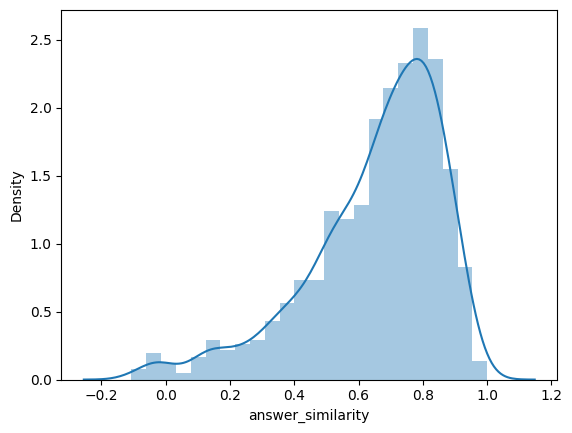

In [110]:
sns.distplot(df_open_mistral_nemo.answer_similarity)